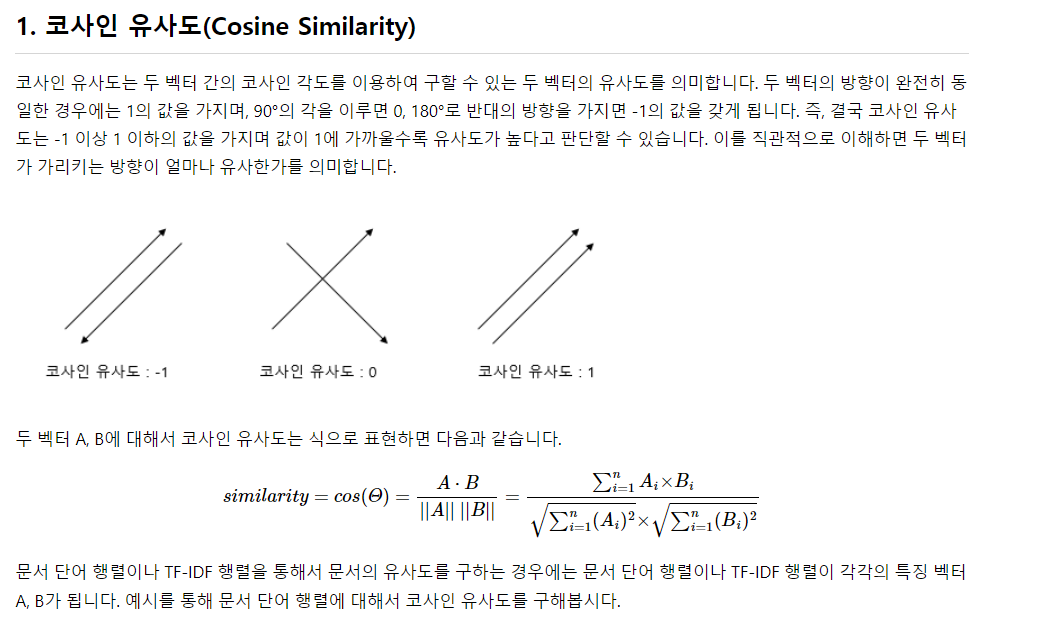

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))
print('문서 1과 문서3의 유사도 :',cos_sim(doc1, doc3))
print('문서 2와 문서3의 유사도 :',cos_sim(doc2, doc3))

문서 1과 문서2의 유사도 : 0.6666666666666667
문서 1과 문서3의 유사도 : 0.6666666666666667
문서 2와 문서3의 유사도 : 1.0000000000000002


## 2. 유사도를 이용한 추천 시스템 구현하기

캐글에서 사용되었던 영화 데이터셋을 가지고 영화 추천 시스템을 만들어보겠습니다. TF-IDF와 코사인 유사도만으로 영화의 줄거리에 기반해서 영화를 추천하는 추천 시스템을 만들 수 있습니다.

다운로드 링크 : https://www.kaggle.com/rounakbanik/the-movies-dataset

원본 파일은 위 링크에서 movies_metadata.csv 파일을 다운로드 받으면 됩니다. 해당 데이터는 총 24개의 열을 가진 45,466개의 샘플로 구성된 영화 정보 데이터입니다.



In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv('movies_metadata.csv', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
# 상위 2만개의 샘플을 data에 저장
data = data.head(20000)

In [4]:
# overview 열에 존재하는 모든 결측값을 전부 카운트하여 출력
print('overview 열의 결측값의 수:',data['overview'].isnull().sum())

overview 열의 결측값의 수: 135


In [5]:
# 결측값을 빈 값으로 대체
data['overview'] = data['overview'].fillna('')

In [6]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print('TF-IDF 행렬의 크기(shape) :',tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (20000, 47487)


In [7]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.01575748, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01575748, 1.        , 0.04907345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04907345, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.08375766],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08375766, 0.        ,
        1.        ]])

In [8]:
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (20000, 20000)


In [9]:
title_to_index = dict(zip(data['title'], data.index))

# 영화 제목 Father of the Bride Part II의 인덱스를 리턴
idx = title_to_index['Father of the Bride Part II']
print(idx)

4


In [10]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다.
    idx = title_to_index[title]

    # 해당 영화와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx])) # [(0, 0.0), (1, 0.006160419774722816),(2, 0.0),(3, 0.0),]

    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # [(18252, 1.0), (12481, 0.32152142350025487),(150, 0.31532758128008986),]

    # 가장 유사한 10개의 영화를 받아온다.
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 영화의 인덱스를 얻는다.
    movie_indices = [idx[0] for idx in sim_scores] # [(12481, 0.32152142350025487), (150, 0.31532758128008986),]

    # 가장 유사한 10개의 영화의 제목을 리턴한다.
    return data['title'].iloc[movie_indices]

In [11]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

In [20]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다.
    idx = title_to_index[title]

    # 해당 영화와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx])) # [(0, 0.0), (1, 0.006160419774722816),(2, 0.0),(3, 0.0),]

    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # [(18252, 1.0), (12481, 0.32152142350025487),(150, 0.31532758128008986),]

    # 가장 유사한 10개의 영화를 받아온다.
    #sim_scores = sim_scores[1:11]
    return sim_scores

In [21]:
get_recommendations('The Dark Knight Rises')

[(18252, 1.0),
 (12481, 0.32152142350025487),
 (150, 0.31532758128008986),
 (1328, 0.30500953745851006),
 (15511, 0.29696687233514857),
 (585, 0.2760295597760307),
 (9230, 0.2362886826517737),
 (18035, 0.20921858266951263),
 (19792, 0.2069989680094894),
 (3095, 0.1962924866191582),
 (10122, 0.17992977744685185),
 (4363, 0.15954901490662235),
 (6042, 0.15771631880952447),
 (11753, 0.1546296074932676),
 (1491, 0.13763604904222643),
 (13838, 0.1353157877838122),
 (1353, 0.13497881134404133),
 (12289, 0.12665359599904213),
 (3267, 0.1256088452269086),
 (18139, 0.11819770352387242),
 (9977, 0.10385380129694169),
 (13789, 0.10304308949212282),
 (3542, 0.10151539251555465),
 (4899, 0.09930772096627247),
 (14301, 0.09833015503982132),
 (14569, 0.09712286326994775),
 (19063, 0.09545444855770552),
 (17838, 0.09531209073740285),
 (13006, 0.09446841703296241),
 (19762, 0.09266687678889397),
 (5610, 0.09187142268327728),
 (17676, 0.0913497146110871),
 (15801, 0.08974548993889228),
 (4414, 0.0890305

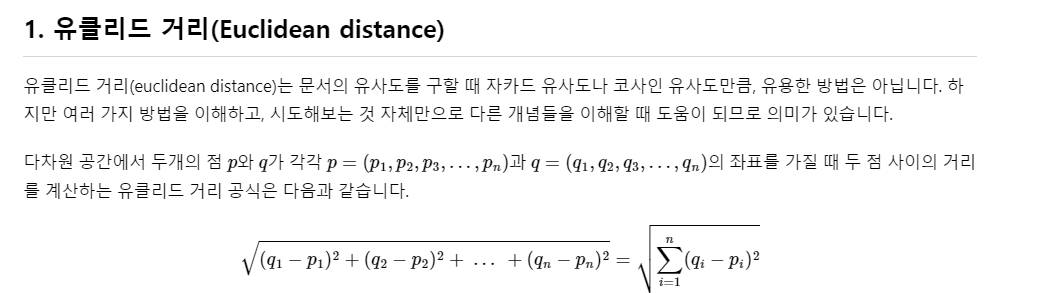

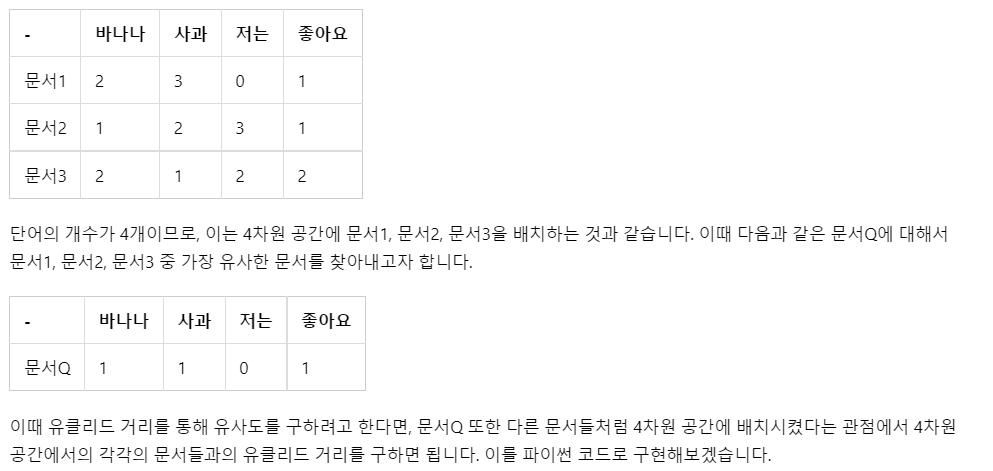

In [22]:
import numpy as np

def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

doc1 = np.array((2,3,0,1))
doc2 = np.array((1,2,3,1))
doc3 = np.array((2,1,2,2))
docQ = np.array((1,1,0,1))

print('문서1과 문서Q의 거리 :',dist(doc1,docQ))
print('문서2과 문서Q의 거리 :',dist(doc2,docQ))
print('문서3과 문서Q의 거리 :',dist(doc3,docQ))

문서1과 문서Q의 거리 : 2.23606797749979
문서2과 문서Q의 거리 : 3.1622776601683795
문서3과 문서Q의 거리 : 2.449489742783178


유클리드 거리의 값이 가장 작다는 것은 문서 간 거리가 가장 가깝다는 것을 의미합니다. 즉, 문서1이 문서Q와 가장 유사하다고 볼 수 있습니다.



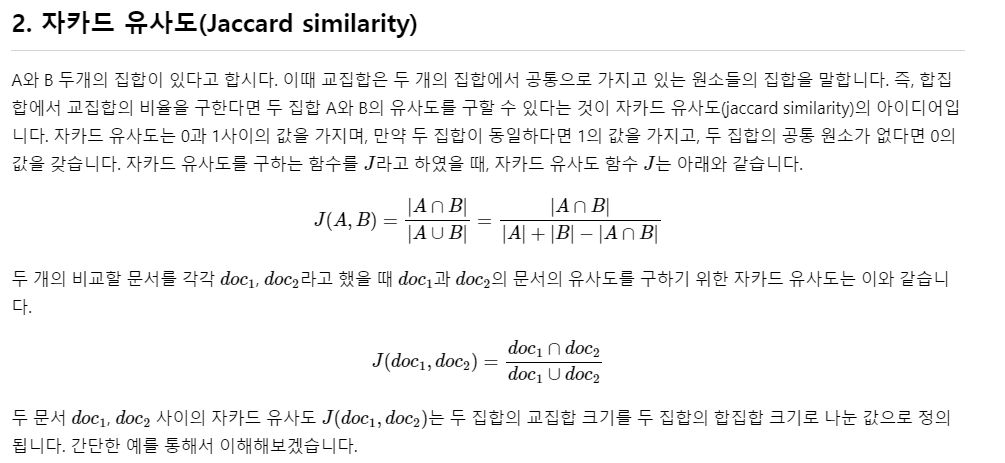

In [23]:
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana coupon passport love you"

# 토큰화
tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

print('문서1 :',tokenized_doc1)
print('문서2 :',tokenized_doc2)

문서1 : ['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
문서2 : ['apple', 'banana', 'coupon', 'passport', 'love', 'you']


In [24]:
union = set(tokenized_doc1).union(set(tokenized_doc2))
print('문서1과 문서2의 합집합 :',union)

문서1과 문서2의 합집합 : {'holder', 'coupon', 'like', 'card', 'love', 'you', 'everyone', 'banana', 'likey', 'passport', 'apple', 'watch'}


In [25]:
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print('문서1과 문서2의 교집합 :',intersection)

문서1과 문서2의 교집합 : {'banana', 'apple'}


In [26]:
print('자카드 유사도 :',len(intersection)/len(union))

자카드 유사도 : 0.16666666666666666
